<a href="https://colab.research.google.com/github/vominhhuy13101999/CPSC-lab-3/blob/main/brainstorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
from math import sqrt,log
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta
from pandas.tseries.offsets import BDay

In [5]:
d={0:0,1:1,2:1,3:2}
def fast_fib(n,d):
  if n in d:
    return d[n]
  else:
    d[n]=fast_fib(n-1,d)+fast_fib(n-2,d)
    return d[n]

def realized_vol(df, end_date=None, lookback=365, gap=1,intra=False,m=15):
#     filtered_df=df.copy()
    filtered_df = df[df.index.to_series().apply(BDay().is_on_offset)]

    if intra:
        return realized_vol_intra(df, end_date, lookback, gap,m)
    # If end date is None, set it to today's date
    if end_date is None:
        end_date = datetime.datetime.today().strftime('%m/%d/%Y')
    # Convert end date to datetime object if it is a string
    if isinstance(end_date, str):
        end_date = datetime.datetime.strptime(end_date, "%m/%d/%Y")
    if isinstance(end_date, pd._libs.tslibs.timestamps.Timestamp):
        pass
    # Set the start date to lookback days before the end date
#     start_date = end_date - pd.Timedelta(days=lookback)
    start_date = end_date - pd.offsets.BDay(lookback)
    # print(start_date,end_date)
    # Filter the DataFrame to only include rows between start_date and end_date
    filtered_df = filtered_df.loc[(filtered_df.index>=start_date) & (filtered_df.index<end_date), 'Close']
    # print(filtered_df)
    diff_2 = np.square(filtered_df.iloc[::gap].pct_change().dropna()*100)
    # Calculate realized volatility
    realized_vol = sqrt(diff_2.sum() / len(diff_2)) * sqrt(252)
    # return realized_vol/filtered_df[0]
    return realized_vol
def realized_vol_intra(df, end_date=None, lookback=365, gap=1,m=15):
    # If end date is None, set it to today's date
    if end_date is None:
        end_date = datetime.datetime.today().strftime('%m/%d/%Y')
    # Convert end date to datetime object if it is a string
    if isinstance(end_date, str):
        end_date = datetime.datetime.strptime(end_date, "%m/%d/%Y")
    if isinstance(end_date, pd._libs.tslibs.timestamps.Timestamp):
        pass
    # Set the start date to lookback days before the end date
    start_date = end_date - pd.Timedelta(days=lookback)
    # print(start_date,end_date)
    # Filter the DataFrame to only include rows between start_date and end_date
    filtered_df = df.loc[(df.index>=start_date) & (df.index<end_date), 'Close']
    # print(filtered_df)
    diff_2 = np.square(filtered_df.iloc[::gap].pct_change().dropna()*100)
    # Calculate realized volatility
    realized_vol = sqrt(diff_2.sum() / len(diff_2)) * sqrt(252)
    # return realized_vol/filtered_df[0]
    return realized_vol
def backtest_strategy(df,threshold=0.5,lookback=30):
    # Filter the DataFrame to only include rows between start_date and end_date
    filtered_df = df.copy()

    # Initialize the position and cash
    position = 0
    cash = 0
    sequence = [1, 3, 8, 21, 55, 144, 377, 987, 2584, 6765, 17711, 46368, 121393, 317811, 832040,2178309,5702887]
    sequence_index = 0
    sell_price=None
    prev_price=None
    # The price at which we bought the stock
    initial_price = None
    c=[]
    p=[]
    # Loop through each row in the DataFrame
    for date, row in filtered_df.iterrows():

        if (date - filtered_df.index[0]).days < lookback:
            continue
#         if cash<0:
#           # print(cash,cash*0.00030)
#           cash+=cash*0.00030
#         if cash>0:
#           # print(cash,cash*0.00030)
#           cash+=cash*0.00010
          # print(cash)
        price = row['Close']
        c.append(cash+position*price)
        p.append(position)
        date_str= date.strftime('%m/%d/%Y %H:%M')
        date=date.strftime('%m/%d/%Y')
#         print(date_str)
        if initial_price is None:
#             if prev_price is None:
#                 prev_price=price
#                 continue
#             elif price<prev_price:
#                 continue
#             else:
#                 prev_price=None
            # Buy the stock
            initial_price = price
            cash -= price * sequence[sequence_index]
            cash += price * position
            position = sequence[sequence_index]

            print(f"{date_str}: Bought {sequence[sequence_index]} at {price}. Cash = {cash}")
            sequence_index += 1

        else:
            # Calculate realized volatility
            lookback1=sequence[sequence_index]
            realized_volatility = realized_vol(filtered_df, end_date=date, lookback=lookback1, gap=1)/100
#             print(price,0.5 * realized_volatility * initial_price)
#             print(date,lookback1)
#             print(realized_volatility)
            if sell_price:
                if price<sell_price:
                  if sequence_index==1:
                    cash += (position-1) * price
                    print(f"{date_str}: Sold {position-1} at {price}. Cash = {cash}")

                    # position = 0
                    # initial_price = None
                    # sequence_index = 0

                    position = 1
                    initial_price = price
                    sequence_index = 1

                    sell_price=None
                    continue
                  initial_price = price

                  sequence_index -= 1



                  cash += price * position

                  cash -= price * sequence[sequence_index]



                  print(f"{date_str}: Sold {position-sequence[sequence_index]} at {price}. Cash = {cash}")

                  position = sequence[sequence_index]



                  sell_price = None

                  # continue
                else:
                    sell_price=price
                continue
            if price > (1 + threshold * realized_volatility) * initial_price:
                sell_price=price
                # Sell the stock
#                 cash += position * price
#                 print(f"{date_str}: Sold {position} at {price}. Cash = {cash}")
#                 position = 0
#                 initial_price = None
#                 sequence_index = 0
#                 break

            elif price < (1 - threshold * realized_volatility) * initial_price:
                # Check if we have not exhausted the sequence
                if sequence_index < len(sequence):
                    # Buy more stock
                    initial_price = price

                    cash -= price * sequence[sequence_index]
                    cash += price * position

                    print(f"{date_str}: Bought {sequence[sequence_index]-position} at {price}. Cash = {cash}")
                    position = sequence[sequence_index]
                    sequence_index += 1

    # Sell any remaining position at the end of the period
    if position > 0:
        cash += position * price
        # print(f"End of period: Sold {position} at {price}. Cash = {cash}")
        c.append(cash)
        p.append(0)
    print(cash)
    return c


In [6]:
def realized_vol_and_skew(df, end_date=None, lookback=365, gap=1):

    filtered_df = df[df.index.to_series().apply(BDay().is_on_offset)]



    if end_date is None:

        end_date = datetime.datetime.today()



    if isinstance(end_date, str):

        end_date = datetime.datetime.strptime(end_date, "%m/%d/%Y")



    start_date = end_date - BDay(lookback)
    # print(start_date,end_date)

    filtered_df = filtered_df.loc[(filtered_df.index >= start_date) & (filtered_df.index <= end_date), 'Close']
    # print(filtered_df)


    returns = filtered_df.iloc[::gap].pct_change().dropna() * 100
    # print(returns)
    diff_2 = np.square(returns)

    # Realized volatility

    realized_vol = sqrt(diff_2.sum() / len(diff_2)) * sqrt(252)



    # Realized skewness

    # mean_return = np.mean(returns)

    # skewness_numerator = (((returns - mean_return)/(realized_vol/100) )** 3).sum()

    # skewness_denominator = realized_vol  # Reusing diff_2 for variance

    skewness_numerator = returns[returns > 0].sum()

    skewness_denominator = abs(returns[returns <= 0].sum())



    # Ensure valid input for logarithm

    if skewness_denominator == 0 or skewness_numerator <= 0:

        realized_skew = 0

    else:

        realized_skew = log(skewness_numerator / skewness_denominator)



    # Cap the skew value to be within [-1, 1]

    realized_skew = max(min(realized_skew, 1), -1)

    return realized_vol, realized_skew





def backtest_strategy_skew(df, lookback=30,base_threshold=0.5):

    filtered_df = df.copy()
    position = 0
    cash = 0
    sequence = [1, 3, 8, 21, 55, 144, 377, 987, 2584, 6765, 17711, 46368, 121393, 317811, 832040,2178309,5702887]
    sequence_index = 0
    initial_price = None
    c = []
    p = []
    sell_price = None
    prev_date=0
    for date, row in filtered_df.iterrows():

        if (date - filtered_df.index[0]).days < lookback:
            continue

        price = row['Close']
        c.append(cash + position * price)
        p.append(cash)

        date_str = date.strftime('%m/%d/%Y %H:%M')

        date = date.strftime('%m/%d/%Y')

        if initial_price is None:

            initial_price = price

            cash -= price * sequence[sequence_index]

            cash += price * position

            position = sequence[sequence_index]

            print(f"{date_str}: Bought {sequence[sequence_index]} at {price}. Cash = {cash}")

            sequence_index += 1

        else:

            lookback1 = sequence[sequence_index]

            realized_volatility, realized_skewness = realized_vol_and_skew(filtered_df, end_date=date, lookback=lookback1, gap=1)

            realized_volatility/=100
            # realized_skewness/=100
            if realized_skewness>0:#>0 represent mean reversion <0 momentum


              sell_threshold = base_threshold*((1-abs(realized_skewness))**1)
              buy_threshold= base_threshold*((1+abs(realized_skewness))**1)
            else:
              sell_threshold = base_threshold*((1+abs(realized_skewness))**1)
              buy_threshold= base_threshold*((1-abs(realized_skewness))**1)
            if position<4:
              sell_threshold=base_threshold
              buy_threshold=base_threshold
            if prev_date!=date:
              print((1 - buy_threshold*realized_volatility) * initial_price,(1 + sell_threshold*realized_volatility) * initial_price)
              prev_date=date
            if sell_price:

                if price < sell_price:
                    if sequence_index==1:

                      cash += (position - 1) * price

                      print(f"{date_str}: Sold {position-1} at {price}. Cash = {cash}")

                      position = 1

                      initial_price = price

                      sequence_index = 1

                      sell_price = None
                      continue

                    initial_price = price

                    sequence_index -= 1

                    cash += price * position

                    cash -= price * sequence[sequence_index]

                    print(f"{date_str}: Sold {position-sequence[sequence_index]} at {price}. Cash = {cash}")
                    print((1 - buy_threshold*realized_volatility) * initial_price,(1 + sell_threshold*realized_volatility) * initial_price)
                    position = sequence[sequence_index]

                    sell_price = None

                    continue

                else:

                    sell_price = price

                    continue

            if price > (1 + sell_threshold*realized_volatility) * initial_price:

                sell_price = price

            elif price < (1 - buy_threshold*realized_volatility) * initial_price and sequence_index < len(sequence):

                initial_price = price

                cash -= price * sequence[sequence_index]

                cash += price * position

                print(f"{date_str}: Bought {sequence[sequence_index]-position} at {price}. Cash = {cash}")
                print((1 - buy_threshold*realized_volatility) * initial_price,(1 + sell_threshold*realized_volatility) * initial_price)
                position = sequence[sequence_index]

                sequence_index += 1

    if position > 0:

        cash += position * price

        c.append(cash)

        p.append(cash)

    print(f"Final Cash: {cash}")

    return c,p

In [61]:
def realized_vol_list(df, s, e=None, lookback=12, gap=1):
    """
    Calculate the list of realized volatilities for given parameters.

    Parameters:
    df : DataFrame : DataFrame containing the time series data
    s : str : Start date in 'MM/DD/YYYY' format
    e : str or None : End date in 'MM/DD/YYYY' format. Default is None, which sets it to today's date.
    lookback : int : Number of months to look back for each calculation
    gap : int : Gap (in terms of the number of records) to apply when sampling the data

    Returns:
    list : List of realized volatilities
    """
    # Filtering trading days
    filtered_df = df[df.index.to_series().apply(BDay().is_on_offset)]
    gap = int(gap)
    l = []

    # Converting to datetime
    s = datetime.datetime.strptime(s, '%m/%d/%Y')
    if e is None:
        e = datetime.datetime.today()
    else:
        e = datetime.datetime.strptime(e, '%m/%d/%Y')

    # Create date range for the analysis
    date_range = filtered_df.index[(filtered_df.index >= s) & (filtered_df.index <= e)]

    for s_ in date_range:
        # Set the end date to lookback months before the current date
        e_ = s_ + pd.offsets.BDay(lookback)

        # Filter the DataFrame for the current window
        window_df = filtered_df[(filtered_df.index >= s_) & (filtered_df.index <= e_)]
        diff = window_df.loc[::gap].pct_change().dropna()*1e2

        if diff.empty:
            diff.loc[window_df.index[-1]] = window_df.loc[window_df.index[-1]] - window_df.loc[window_df.index[0]]
        elif window_df.index[-1] not in diff.index:
            diff.loc[window_df.index[-1]] = window_df.loc[window_df.index[-1]] - window_df.loc[diff.index[-1]]

        diff_2 = np.square(diff)
        realized_vol = sqrt(diff_2.sum() / len(diff_2)) * sqrt(252 / gap)
        l.append(realized_vol)

    return l

def realized_implied_plot(df, start_date, end_date=None, lookback=12, gap=1):
    """
    Plot realized volatilities over time.

    Parameters:
    df : DataFrame : DataFrame containing the time series data
    start_date : str : Start date in 'MM/DD/YYYY' format
    end_date : str or None : End date in 'MM/DD/YYYY' format. Default is None, which sets it to today's date.
    lookback : int : Number of months to look back for each calculation
    gap : int : Gap (in terms of number of records) to apply when sampling the data
    """

    realized_vols = realized_vol_list(df, start_date, end_date, lookback, gap)
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')[:len(realized_vols)]

    df_ = pd.DataFrame({
        'Date': date_range,
        'Realized': realized_vols
    })

    fig, ax = plt.subplots(figsize=(14, 8))
    df_.plot(x='Date', y='Realized', ax=ax, color='#7cd33a')
    ax.set_xlabel("Time")
    ax.set_ylabel("Realized Volatility (%)")
    ax.grid(True)
    plt.title("Realized Volatility (%)", fontsize=22)
    plt.show()

In [62]:
# # Define the ticker symbol
tickerSymbol = 'spy'

# # Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
end='2024-08-20'
end1='08/20/2024'

df = tickerData.history(period='1d', start='2000-1-1', end=end)
df.index=df.index.tz_localize(None)
daily_realized= realized_vol(df, end_date=end1, lookback=3, gap=1)

df1 = tickerData.history(period='1d',interval="30m", start='2024-6-24', end=end)
df1.index=df1.index.tz_localize(None)
# df = df[df.index.to_series().apply(BDay().is_on_offset)]

# daily_realized=realized_vol(df, end_date='11/09/2023', lookback=1, gap=1)
realized_volatility=realized_vol(df1, end_date=end1, lookback=21, gap=1)
# realized_volatility=realized_vol(df, end_date='06/30/2023', lookback=8, gap=1)

# print(realized_volatility)
threshold_d=1
threshold_m=1
initial_price_d=4017
initial_price_m=3150
print("daily : ",daily_realized)
print("price_d_sell:",(1 + threshold_d * daily_realized/100) * (initial_price_d+10))
print("price_d_buy:",(1 - threshold_d * daily_realized/100) * (initial_price_d-10))
print()
print("15mins : ",realized_volatility)
print("price_min_sell:",(1 + threshold_m * realized_volatility/100) * (initial_price_m+10))
print("price_min_buy:",(1 - threshold_m * realized_volatility/100) * (initial_price_m-10))

daily :  11.023772802714864
price_d_sell: 4470.9273307653275
price_d_buy: 3565.2774237952153

15mins :  6.132134917279292
price_min_sell: 3353.7754633860254
price_min_buy: 2947.45096359743


In [63]:
realized_vol_list(df["Close"], s="10/13/2014", e=end1, lookback=7,gap=1)

[16.163595253775345,
 17.579707074185485,
 17.716773870679948,
 17.72848355378982,
 17.647849491426506,
 16.683202996169396,
 12.322053464831196,
 13.442725668837623,
 11.496391403968378,
 10.732257210535284,
 11.351830563399389,
 9.34172512321702,
 9.3144802240096,
 8.690843932712527,
 5.366473211158698,
 5.395351054553364,
 5.0233681165151856,
 3.30044287250803,
 2.2956754796387986,
 4.117923018986682,
 3.7840625603792337,
 3.8833960639673433,
 4.996974867818314,
 5.229493485418256,
 5.2454363826470205,
 5.452138958123731,
 4.54726033877366,
 4.63480864694883,
 6.361890348999978,
 6.782098587415854,
 6.996937064820689,
 7.017929111242439,
 6.901259004248964,
 7.446306935500518,
 11.427398970624708,
 11.171304520031562,
 14.609992774039211,
 15.165782043709916,
 15.880407246858947,
 19.351451574914755,
 24.381382912385888,
 22.54872196346554,
 22.512422216187534,
 20.333177224750415,
 19.91109269244077,
 20.869039795979674,
 16.687025465942497,
 4.731434043285829,
 5.184256277095074,


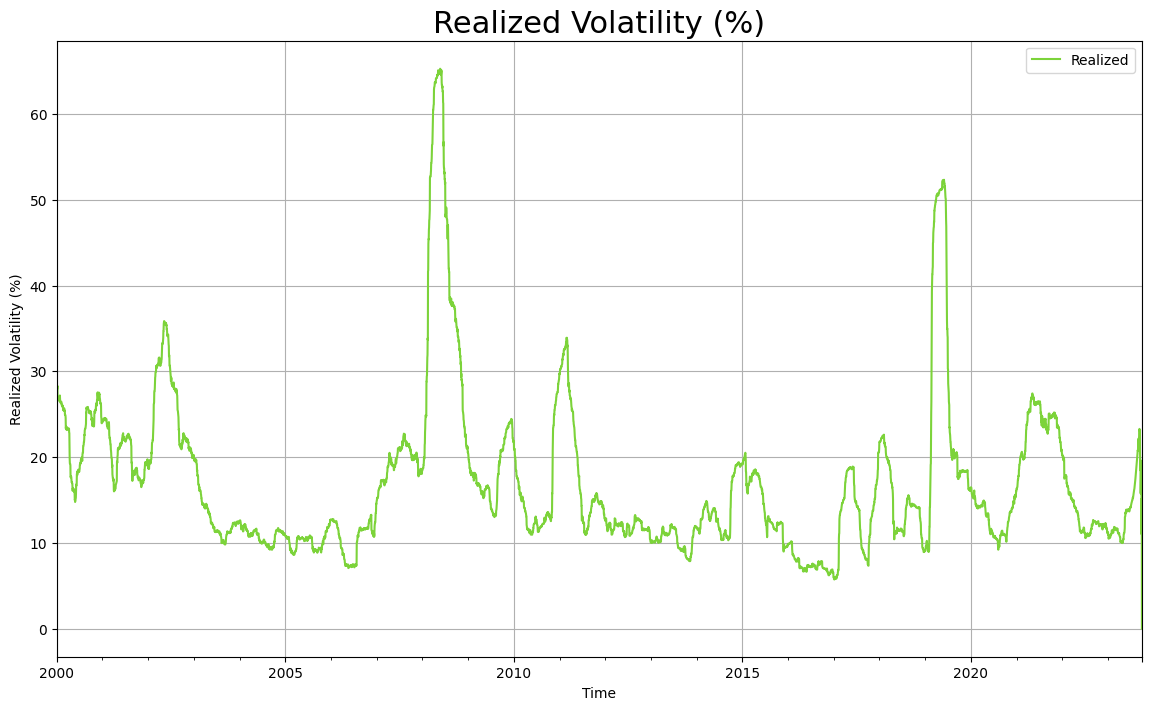

In [70]:
realized_implied_plot(df["Close"], "1/1/2000", end1, lookback=90, gap=1)

In [59]:
df["Close"]

,Close
Date,
2000-09-13,95.973320
2000-09-14,96.456772
2000-09-15,94.346504
2000-09-18,93.478157
2000-09-19,94.326324
...,...
2024-08-13,542.039978
2024-08-14,543.750000
2024-08-15,553.070007
